In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from torch_geometric.loader import DataLoader
from dataset_copy import *
from model import *
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
torch_geometric.seed_everything(2023)
device = 'cpu'

Dataset type:  <class 'dataset_copy.ChiralLigands'>
Dataset node features:  6
Dataset length:  <bound method ChiralLigands.len of ChiralLigands(106)>
Dataset sample:  Data(x=[147, 6], edge_index=[2, 314], edge_attr=[314, 2], y=[1], category=[1], ligand='O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)c1ccccc1P(c1ccccc1)c1ccccc1)c1ccccc1P(c1ccccc1)c1ccccc1', substrate='C=CC[C@]1(c2ccccc2)CCCC1=O', solvent='C1COCCO1', ligand_num='III', ligand_id='(R,R)-L3', idx=0)
Sample features:  tensor([[ 8.,  1.,  3.,  0.,  0.,  0.],
        [ 6.,  3.,  3.,  0.,  0.,  0.],
        [ 7.,  3.,  3.,  0.,  0.,  0.],
        [ 6.,  4.,  4.,  0.,  1.,  2.],
        [ 6.,  4.,  4.,  0.,  1.,  0.],
        [ 6.,  3.,  3.,  1.,  1.,  0.],
        [ 6.,  3.,  3.,  1.,  1.,  0.],
        [ 6.,  3.,  3.,  1.,  1.,  0.],
        [ 6.,  3.,  3.,  1.,  1.,  0.],
        [ 6.,  3.,  3.,  1.,  1.,  0.],
        [ 6.,  3.,  3.,  1.,  1.,  0.],
        [ 6.,  4.,  4.,  0.,  1.,  0.],
        [ 6.,  3.,  3.,  1.,  1.,  0.

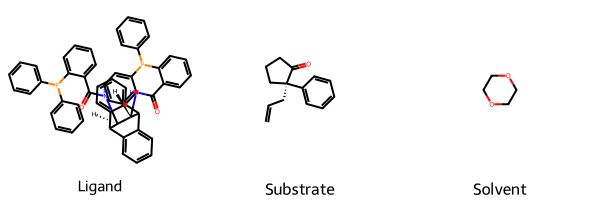

In [3]:
ligands = ChiralLigands(root = '/Users/ed_aguilar/Documents/PhD_Documents/Experiments/Declan/data', filename = 'DAAA-final.csv')

print("Dataset type: ", type(ligands))
print("Dataset node features: ", ligands.num_features)
print("Dataset length: ", ligands.len)
print("Dataset sample: ", ligands[0])
print('Sample features: ',  ligands[0].x)
print('Sample outcome: ',  ligands[0].y)
print('Sample cat: ',  ligands[0].category)

ms = [ligands[0].ligand, ligands[0].substrate, ligands[0].solvent]
ms = [Chem.MolFromSmiles(mol) for mol in ms]
Chem.Draw.MolsToGridImage(ms,molsPerRow=3,subImgSize=(200,200),legends=['Ligand', 'Substrate', 'Solvent']) 

In [4]:
indices_to_drop = [73,100,105,179,206,211]
indices_to_keep = [i for i in range(len(ligands)) if ligands[i].idx not in indices_to_drop]
ligands = ligands[indices_to_keep]

In [5]:
#model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=True)
#model = GAT_loop(ligands.num_features, embedding_size = 64, gnn_layers=3, nheads=1, concat=False)
model = NN_model(ligands.num_features, ligands.num_edge_features, 50)
model.to(device)

NN_model(
  (conv1): NNConv(6, 50, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=300, bias=True)
    (1): ReLU()
  ))
  (lin1): Linear(in_features=100, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=1, bias=True)
)

In [6]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

In [7]:
categories = np.array([ligands[i].category.detach().numpy() for i in range(len(ligands))])
x = [ligands[i].x.detach().numpy() for i in range(len(ligands))]
groups = [ligands[i].ligand_num for i in range(len(ligands))]

In [8]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, categories)):
    train_idx.append(train)
    test_idx.append(test)

In [9]:
i = 3
train_loader = DataLoader(ligands[train_idx[i]], batch_size=40, shuffle=True)
test_loader = DataLoader(ligands[test_idx[i]], batch_size=40, shuffle=False)

In [10]:
def calculate_metrics(y_pred, y_true, epoch, data):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))

    if epoch % 5 == 0:
        print(data)
        print(f'R2: {r2:.2f}')
        print(f'MAE: {mae:.2f}')
        print(f'RMSE: {rmse:.2f} \n')

    return r2, mae, rmse

In [11]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.edge_attr,
                  batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))    
      loss.backward()  
      # Update using the gradients
      optimizer.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [12]:
def test(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in test_loader:
      # Use GPU
      batch.to(device)  
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.edge_attr,
                  batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))    

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [13]:
epochs = 2501
best_loss = 10_000

loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []


for epoch in range (epochs):
            # Training
            model.train()
            loss, pred, label, metrics = train(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if epoch % 5 == 0:
                loss_train.append(loss) 

            if epoch % 100 == 0:
               print(f"Epoch {epoch} | Train Loss {loss}")
               pred_train.append(pred)
               labels_train.append(label)

            if epoch % 5 ==0:
                model.eval()
                loss, pred, label, metrics = test(epoch=epoch)

                if epoch%10 == 0:
                    loss = loss.detach().cpu().numpy()
                    loss_test.append(loss)
            
                if float(loss) < best_loss:
                    best_loss = loss
                    early_stopping_counter = 0
                    best_pred = pred
                    best_y = label
                    best_epoch = epoch
                    best_r2 = metrics[0]
                    best_mae = metrics[1]
                    best_rmse = metrics[2]


    
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Test Loss {loss}")
                pred_test.append(pred)
                labels_test.append(label)
            


train
R2: -5.30
MAE: 70.17
RMSE: 76.66 

Epoch 0 | Train Loss 74.74153900146484
test
R2: -3.37
MAE: 62.09
RMSE: 69.67 

Epoch 0 | Test Loss 69.66974639892578
train
R2: -0.05
MAE: 24.76
RMSE: 31.29 

test
R2: -0.11
MAE: 33.45
RMSE: 35.07 

train
R2: -0.07
MAE: 24.13
RMSE: 31.56 

test
R2: 0.00
MAE: 29.38
RMSE: 33.30 

train
R2: -0.06
MAE: 24.17
RMSE: 31.41 

test
R2: -0.02
MAE: 26.58
RMSE: 33.69 

train
R2: 0.03
MAE: 25.75
RMSE: 30.01 

test
R2: 0.01
MAE: 27.53
RMSE: 33.22 

train
R2: 0.02
MAE: 25.90
RMSE: 30.23 

test
R2: 0.02
MAE: 29.21
RMSE: 32.99 

train
R2: 0.04
MAE: 24.55
RMSE: 29.93 

test
R2: 0.02
MAE: 27.80
RMSE: 32.93 

train
R2: 0.06
MAE: 24.79
RMSE: 29.67 

test
R2: 0.03
MAE: 27.75
RMSE: 32.80 

train
R2: 0.06
MAE: 24.60
RMSE: 29.68 

test
R2: 0.04
MAE: 27.75
RMSE: 32.64 

train
R2: 0.08
MAE: 24.12
RMSE: 29.36 

test
R2: 0.05
MAE: 27.80
RMSE: 32.46 

train
R2: 0.10
MAE: 24.67
RMSE: 28.92 

test
R2: 0.05
MAE: 29.80
RMSE: 32.55 

train
R2: 0.09
MAE: 26.03
RMSE: 29.08 

test
R2

In [14]:
print(f'Best test R2: {best_r2}')
print(f'Best test MAE: {best_mae}')
print(f'Best test RMSE: {best_rmse}')
print(f'Best epoch: {best_epoch}')

Best test R2: 0.9200667194977413
Best test MAE: 7.477791786193848
Best test RMSE: 9.426841527602097
Best epoch: 2375


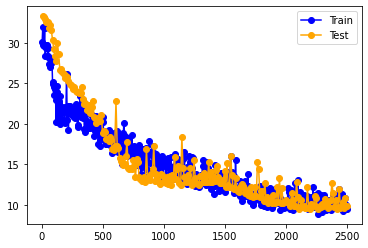

In [15]:
n=1

plt.plot(range(0,epochs,5)[n:], loss_train[n:], 'o-', label = 'Train', color = 'blue')
plt.plot(range(0,epochs,10)[n:], loss_test[n:], 'o-', label = 'Test', color = 'orange')
plt.legend()
plt.show()

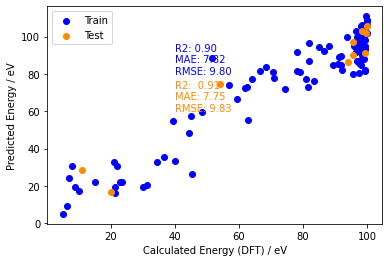

In [16]:
e = 25

plt.scatter(labels_train[e], pred_train[e], color = 'blue', label = 'Train')
plt.scatter(labels_test[e], pred_test[e], color = 'darkorange', label = 'Test')
plt.xlabel("Calculated Energy (DFT) / eV")
plt.ylabel("Predicted Energy / eV")
plt.legend()

plt.text(40, 80, f'R2: {r2_score(labels_train[e], pred_train[e]):.2f} \n\
MAE: {mean_absolute_error(labels_train[e], pred_train[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_train[e], pred_train[e])):.2f}', color = 'b')

plt.text(40, 60, f'R2:  {r2_score(labels_test[e], pred_test[e]):.2f}\n\
MAE: {mean_absolute_error(labels_test[e], pred_test[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_test[e], pred_test[e])):.2f}', color = 'darkorange')
plt.show()

In [12]:
def train_folds(epoch, model, optimiser, loader):

    all_preds = []
    all_y = []

    index = []

    ligand = []
    boron = []
    substrate = []

    total_loss = 0
    step = 0

    for batch in loader:

      # Use GPU
      batch.to(device)  

      # Reset gradients
      optimiser.zero_grad() 

      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.edge_attr,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))    
      loss.backward()  

      # Update using the gradients
      optimiser.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())
      index.append(batch.idx)

  

      ligand.append(batch.ligand)
      boron.append(batch.solvent)
      substrate.append(batch.substrate)

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    index = np.concatenate(index).ravel()


    ligand = np.expand_dims(np.concatenate(ligand).ravel(), 1)
    boron = np.expand_dims(np.concatenate(boron).ravel(),1)
    substrate = np.expand_dims(np.concatenate(substrate).ravel(),1)
    smiles = np.concatenate((ligand, boron, substrate), axis = 1)

    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics, smiles, index

In [13]:
def test_folds(epoch, model, loader):

    all_preds = []
    all_y = []

    index = []
    family = []

    ligand = []
    boron = []
    substrate = []

    total_loss = 0
    step = 0

    for batch in loader:

      # Use GPU
      batch.to(device)  

      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.edge_attr,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())
      index.append(batch.idx)


      ligand.append(batch.ligand)
      boron.append(batch.solvent)
      substrate.append(batch.substrate)

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    index = np.concatenate(index).ravel()


    ligand = np.expand_dims(np.concatenate(ligand).ravel(), 1)
    boron = np.expand_dims(np.concatenate(boron).ravel(),1)
    substrate = np.expand_dims(np.concatenate(substrate).ravel(),1)
    smiles = np.concatenate((ligand, boron, substrate), axis = 1)

    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics, smiles, index

In [14]:
epochs = 2501

#folds x times loss is saved
loss_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
loss_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
r2_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
r2_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
mae_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
mae_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
rmse_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
rmse_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#each element of the list holds a fold, first entry of the np array is the number of data points and second number of times stored
pred_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
pred_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
ee_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
ee_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
smiles_train_folds = [[[[None] *3] * len(train_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 
smiles_test_folds = [[[[None] *3] * len(test_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 

#times lables are saved x number of predictions x folds
index_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
index_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
family_train_folds = [[[None] * len(train_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 
family_test_folds = [[[None] * len(test_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 


best_loss_f = [None] * len(train_idx)
best_pred_f = [None] * len(train_idx)
best_y_f = [None] * len(train_idx)
best_r2_f = [None] * len(train_idx)
best_mae_f = [None] * len(train_idx)
best_rmse_f = [None] * len(train_idx)
best_epoch_f = [None] * len(train_idx)

In [15]:
for fold in range(len(train_idx)):

    model = NN_model(ligands.num_features, ligands.num_edge_features, 50)
    #model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=False)
    model.to(device)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    train_loader = DataLoader(ligands[train_idx[fold]], batch_size=40, shuffle=True)
    test_loader = DataLoader(ligands[test_idx[fold]], batch_size=40, shuffle=False)

    best_loss = 1_000


    for epoch in range (epochs):

        # Training
        model.train()
        loss, pred, label, metrics, smiles, index = train_folds(epoch=epoch,
                                                                model = model,
                                                                optimiser = optimizer,
                                                                loader = train_loader)
        
        loss = loss.detach().cpu().numpy()

        if epoch % 5 == 0:
            loss_train_folds[fold, int(epoch / 5)] = loss
            r2_train_folds[fold, int(epoch / 5)] = metrics[0]
            mae_train_folds[fold, int(epoch / 5)] = metrics[1]
            rmse_train_folds[fold, int(epoch / 5)] = metrics[2]

        if epoch % 5 == 0:
            print(f"Epoch {epoch} | Fold {fold} | Train Loss {loss} \n")
            pred_train_folds[fold][:, int(epoch/5)] = pred
            ee_train_folds[fold][:, int(epoch/5)] = label
            smiles_train_folds[fold][int(epoch/5)] = smiles
            index_train_folds[fold][:, int(epoch/5)] = index


        # Testing

        if epoch % 5 == 0:
            model.eval()
            loss, pred, label, metrics, smiles, index = test_folds(epoch=epoch,
                                                                   model=model,
                                                                   loader = test_loader)
            loss = loss.detach().cpu().numpy() 

            if float(loss) < best_loss:
                best_loss = loss
                best_loss_f[fold] = loss
                best_pred_f[fold] = pred
                best_y_f[fold] = label
                best_r2_f[fold] = metrics[0]
                best_mae_f[fold] = metrics[1]
                best_rmse_f[fold] = metrics[2]
                best_epoch_f[fold] = epoch

            if epoch % 5 == 0:
                loss_test_folds[fold, int(epoch / 5)] = loss
                r2_test_folds[fold, int(epoch / 5)] = metrics[0]
                mae_test_folds[fold, int(epoch / 5)] = metrics[1]
                rmse_test_folds[fold, int(epoch / 5)] = metrics[2]

                print(f"Epoch {epoch} | Fold {fold} | Test Loss {loss} \n")
                pred_test_folds[fold][:, int(epoch/5)] = pred
                ee_test_folds[fold][:, int(epoch/5)] = label
                smiles_test_folds[fold][int(epoch/5)] = smiles
                index_test_folds[fold][:, int(epoch/5)] = index

    
    print(f'Done for fold {fold}')
    print(f'Best loss: {best_loss_f[fold]}')
    print(f'Best r2: {best_r2_f[fold]}')
    print(f'Best mae: {best_mae_f[fold]}')
    print(f'Best rmse: {best_rmse_f[fold]}')
    print(f'Best epoch: {best_epoch_f[fold]}')

train
R2: -4.67
MAE: 66.55
RMSE: 73.25 

Epoch 0 | Fold 0 | Train Loss 69.95320129394531 

test
R2: -2.25
MAE: 50.82
RMSE: 56.57 

Epoch 0 | Fold 0 | Test Loss 56.56654739379883 

train
R2: -0.30
MAE: 32.47
RMSE: 35.04 

Epoch 5 | Fold 0 | Train Loss 34.34811782836914 

test
R2: -0.23
MAE: 32.85
RMSE: 34.77 

Epoch 5 | Fold 0 | Test Loss 34.76774215698242 

train
R2: -0.03
MAE: 27.96
RMSE: 31.17 

Epoch 10 | Fold 0 | Train Loss 31.1207275390625 

test
R2: -0.10
MAE: 30.59
RMSE: 32.90 

Epoch 10 | Fold 0 | Test Loss 32.90483856201172 

train
R2: 0.00
MAE: 27.03
RMSE: 30.76 

Epoch 15 | Fold 0 | Train Loss 30.999547958374023 

test
R2: -0.02
MAE: 28.59
RMSE: 31.76 

Epoch 15 | Fold 0 | Test Loss 31.756006240844727 

train
R2: 0.01
MAE: 27.36
RMSE: 30.60 

Epoch 20 | Fold 0 | Train Loss 31.60279655456543 

test
R2: -0.04
MAE: 29.40
RMSE: 32.08 

Epoch 20 | Fold 0 | Test Loss 32.08389663696289 

train
R2: 0.03
MAE: 27.13
RMSE: 30.35 

Epoch 25 | Fold 0 | Train Loss 31.572250366210938 

tes

In [17]:
mean_r2_test = []
std_r2_test = []

mean_mae_test = []
std_mae_test = []

mean_rmse_test = []
std_rmse_test = []

for i in range(len(range(0,epochs,5))):

    mean_r2_test.append(np.mean(r2_test_folds[:,i]))
    std_r2_test.append(np.std(r2_test_folds[:,i]))

    mean_mae_test.append(np.mean(mae_test_folds[:,i]))
    std_mae_test.append(np.std(mae_test_folds[:,i]))

    mean_rmse_test.append(np.mean(rmse_test_folds[:,i]))
    std_rmse_test.append(np.mean(rmse_test_folds[:,i]))

In [18]:
print(f'e value for best r2: {mean_r2_test.index(max(mean_r2_test))}')
print(f'e value for best mae: {mean_mae_test.index(min(mean_mae_test))}')
print(f'e value for best rmse: {mean_rmse_test.index(min(mean_rmse_test))}')

all = [sum(x) for x in zip(mean_mae_test, mean_rmse_test)]
print(f'e value for best General: {all.index(min(all))}')

e value for best r2: 348
e value for best mae: 275
e value for best rmse: 228
e value for best General: 496


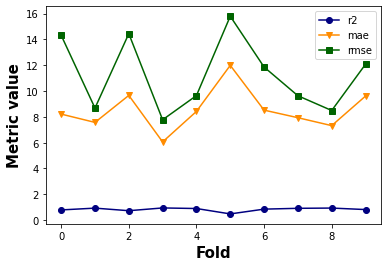

In [19]:
e = 496
plt.plot(figsize =(24, 16))
plt.plot(range(len(train_idx)), r2_test_folds[:,e], 'o-', label = 'r2', color = 'navy')
plt.plot(range(len(train_idx)), mae_test_folds[:,e], 'v-', label = 'mae', color = 'darkorange')
plt.plot(range(len(train_idx)), rmse_test_folds[:,e], 's-', label = 'rmse', color = 'darkgreen')


plt.xlabel('Fold', fontweight ='bold', fontsize = 15)
plt.ylabel('Metric value', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

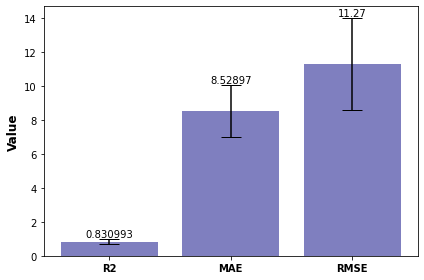

[0.13402132981033693, 1.5282792856330083, 2.696749740720081]


In [20]:
e = 496
Metrics = ['R2', 'MAE', 'RMSE']
x_pos = np.arange(len(Metrics))
CTEs = [np.mean(r2_test_folds[:,e]), np.mean(mae_test_folds[:,e]), np.mean(rmse_test_folds[:,e])]
error = [np.std(r2_test_folds[:,e]), np.std(mae_test_folds[:,e]), np.std(rmse_test_folds[:,e])]

fig, ax = plt.subplots(figsize =(6, 4))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', color = 'navy', alpha=.5, ecolor='black', capsize=10)
ax.set_ylabel('Value', fontweight ='bold', fontsize = 12)
ax.bar_label(bars)
ax.set_xticks(x_pos)
ax.set_xticklabels(Metrics, fontweight ='bold' ,fontsize = 10)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()
print(error)

In [21]:
e = 357
df = pd.DataFrame()

for f in range(len(train_idx)):
    fs = [f for _ in range(len(test_idx[f]))]
    data_set = ['test' for _ in range(len(test_idx[f]))]

    data = {
        'ee': ee_test_folds[f][:,e],
        'Prediction': pred_test_folds[f][:,e],
        'Ligand': smiles_test_folds[f][e][:,0],
        'Boron_reagent': smiles_test_folds[f][e][:,1],
        'Substrate': smiles_test_folds[f][e][:,2], 
        'family': family_test_folds[f][e],
        'index': index_test_folds[f][:,e],
        'fold': f,
        'set': data_set
    }

    df_f = pd.DataFrame(data)
    df = pd.concat([df, df_f], axis = 0)

    data_set = ['train' for _ in range(len(train_idx[f]))]

    data = {
    'ee': ee_train_folds[f][:,e],
    'Prediction': pred_train_folds[f][:,e],
    'Ligand': smiles_train_folds[f][e][:,0],
    'Boron_reagent': smiles_train_folds[f][e][:,1],
    'Substrate': smiles_train_folds[f][e][:,2], 
    'family': family_train_folds[f][e],
    'index': index_train_folds[f][:,e],
    'fold': f,
    'set': data_set
    }

    df_f = pd.DataFrame(data)
    df = pd.concat([df, df_f], axis = 0)



df = df.set_index('index')
df['error'] = df['ee'] - df['Prediction']
df

,ee,Prediction,Ligand,Boron_reagent,Substrate,family,fold,set,error
index,,,,,,,,,
12.0,99.750000,102.770813,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,C1COCCO1,C=CC[C@]1(c2c(OCc3ccccc3)ccc3ccccc23)CCCC1=O,None,0,test,-3.020813
15.0,98.500000,104.859924,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,COC(C)(C)C,C=CC[C@]1(c2c(OC)cc(OC)cc2OC)CCCC1=O,None,0,test,-6.359924
16.0,99.300003,104.369324,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,COCCOC,C=CC[C@]1(c2c(OC)cc(OC)cc2OC)CCCC1=O,None,0,test,-5.069321
18.0,71.000000,82.022110,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,C1COCCO1,C=CC[C@]1(c2ccc(OC)cc2)CCOC1=O,None,0,test,-11.022110
43.0,97.000000,97.004700,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,C1COCCO1,C=CC[C@]1(c2c(OC)ccc3ccccc23)CCCOC1=O,None,0,test,-0.004700
...,...,...,...,...,...,...,...,...,...
86.0,95.500000,97.335915,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,COC(C)(C)C,C=CC[C@@]1(c2c(OC)cc(OC)cc2OC)C(=O)N(C)c2ccccc21,None,9,train,-1.835915
35.0,94.000000,82.510246,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,C1COCCO1,C=CC[C@]1(c2ccc(OC)cc2OC)CCCOC1=O,None,9,train,11.489754
85.0,98.500000,97.450203,O=C(N[C@@H]1C2c3ccccc3C(c3ccccc32)[C@H]1NC(=O)...,CC1CCCO1,C=CC[C@@]1(c2c(OC)cc(OC)cc2OC)C(=O)N(C)c2ccccc21,None,9,train,1.049797


In [31]:
df.to_csv(f'/Users/ed/Documents/PhD_Documents/Experiments/ChiralLigands/Data_augm_exp/GNN/plots_regr/ligands_allfolds_e{e}_NN_epochs_{e*5}.csv')